## Seattle AirBNB dataset

## Questions of interest:

- Neighbourhood differences in price
- Neighbourhood differences in availabilty
- can we predict price for a house?
- can we predict reviews for a house?
- can we predict availability for a house?

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

%matplotlib inline

In [2]:
#load data
calendar = pd.read_csv('seattle_calendar.csv')
listings = pd.read_csv('seattle_listings.csv')
reviews = pd.read_csv('seattle_reviews.csv')

In [3]:
#create backup copy
calendar_copy = calendar.copy()
listings_copy = listings.copy()
reviews_copy = reviews.copy()

In [4]:
#overview of shape and composition calendar
print(calendar.shape)
print(calendar.dtypes)
print(calendar.info())

(1393570, 4)
listing_id     int64
date          object
available     object
price         object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None


In [5]:
calendar.date.nunique()

365

For every house, we have the information of price and availability day by day. In total, it adds up to over 1 million observations

Data quality issues calendar df:
    - convert date to datetype
    - convert available to boolean
    - convert price to int/float

In [6]:
#overview of shape and composition reviews
print(reviews.shape)

(84849, 6)


In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [8]:
#return counts greater than 1
reviews['reviewer_id'].value_counts().loc[lambda x : x>5]

206203      67
15121499    32
5775807     19
2734499     19
29590276    18
            ..
423381       6
594768       6
19235033     6
13120075     6
63815        6
Name: reviewer_id, Length: 160, dtype: int64

In [9]:
reviews.comments[16]

'Despite our late booking request, Rachel & Jon were very responsive and helpful over email. It was a great place to stay - the location was ideal, the house was clean, well-furnished, the room was cozy, and the cat made good company. Overall, a lovely experience and I would definitely recommend the Farmhouse! '

For every house, we have the written reviews recieved and who made them.

Data quality issues listings df:
    - convert date to datetype

In [10]:
#overview of shape and composition listings
print(listings.shape)
print(listings.dtypes)

(3818, 92)
id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object


This dataframe gives information about several aspects of the booking. Can be divided in sections, host, house description, neighbourhood, booking conditions, reviews.

In [11]:
listings_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Quality issues in listings df:
    - drop license column DONE
    - drop neighbourhood, work with neighbourhood_group_cleansed and neighborhood_cleansed columns DONE
    - drop square feet DONE
    - neighborhood_overview copy according to neighbourhood_cleansed
    - space create dummy variable or count words
    - notes create dummy variable or count words
    - transit create dummy variable
    - thumbnail_url create dummy variable DONE
    - medium_url create dummy variable DONE
    - xl_picture_url create dummy variable DONE
    - host_about create count words
    - host_acceptance_rate, host_response_rate and host_response_time fill with mode DONE
    - host_is_superhost convert to bool DONE
    - weekly price and monthly price to int. a lot of nans DONE
    - security_deposit, cleaning_fee fill with 0 DONE
    - first and last review to dtype DONE
    - review_scores how to deal with houses without review? fill with mean? DONE

In [12]:
listings.street

0           Gilman Dr W, Seattle, WA 98119, United States
1       7th Avenue West, Seattle, WA 98119, United States
2       West Lee Street, Seattle, WA 98119, United States
3       8th Avenue West, Seattle, WA 98119, United States
4            14th Ave W, Seattle, WA 98119, United States
                              ...                        
3813    Northwest 48th Street, Seattle, WA 98107, Unit...
3814    Fuhrman Avenue East, Seattle, WA 98102, United...
3815    South Laurel Street, Seattle, WA 98178, United...
3816    43rd Avenue East, Seattle, WA 98112, United St...
3817    Westlake Avenue North, Seattle, WA 98109, Unit...
Name: street, Length: 3818, dtype: object

### Wrangle data

#### calendar df

In [13]:
#convert to boolean available column
d = {'t': 1, 'f': 0}
calendar['available'] = calendar["available"].replace(d)

In [14]:
#convert date to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

Price column contains several missing values, since it is a stationary feature, it will be filled with the last observation instead of the mean.

In [15]:
#convert price to int and fill na
calendar['price'] = calendar.price.str.replace('$', '').str.replace(',', '').astype(float).fillna(method='ffill')

In [16]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
2,241032,2016-01-06,0,85.0
3,241032,2016-01-07,0,85.0
4,241032,2016-01-08,0,85.0


#### reviews df

In [17]:
#reviews date to datetype
reviews['date'] = pd.to_datetime(reviews['date'])

#### listings df

All variables t or f are going to be converted to boolean

In [18]:
#convert to bool type
d = {'t': 1, 'f': 0}
listings['host_is_superhost'] = listings["host_is_superhost"].replace(d)#.astype(bool)
listings['has_availability'] = listings["has_availability"].replace(d)#.astype(bool)
listings['require_guest_profile_picture'] = listings["require_guest_profile_picture"].replace(d)#.astype(bool)
listings['require_guest_phone_verification'] = listings["require_guest_phone_verification"].replace(d)#.astype(bool)
listings['instant_bookable'] = listings["instant_bookable"].replace(d)#.astype(bool)
listings['requires_license'] = listings["requires_license"].replace(d)#.astype(bool)
listings['is_location_exact'] = listings["is_location_exact"].replace(d)#.astype(bool)
listings['host_identity_verified'] = listings["host_identity_verified"].replace(d)#.astype(bool)
listings['host_has_profile_pic'] = listings["host_has_profile_pic"].replace(d)#.astype(bool)

Fill missing values with mode in categorical variables and convert to int those where it is possible. Remove from variable $ and % signs

In [19]:
#host_acceptance_rate, host_response_rate and host_response_time fill with mode
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].fillna(listings['host_acceptance_rate'].mode()[0])
listings['host_response_rate'] = listings['host_response_rate'].fillna(listings['host_response_rate'].mode()[0])
listings['host_response_time'] = listings['host_response_time'].fillna(listings['host_response_time'].mode()[0])
listings['host_neighbourhood'] = listings['host_neighbourhood'].fillna(listings['host_neighbourhood'].mode()[0])

In [20]:
listings['host_acceptance_rate'] = listings.host_acceptance_rate.str.replace('%', '').astype(int)
listings['host_response_rate'] = listings.host_response_rate.str.replace('%', '').astype(int)
listings['security_deposit'] = listings.security_deposit.str.replace('$', '').str.replace(',','').fillna(0).astype(float)
listings['cleaning_fee'] = listings.cleaning_fee.str.replace('$', '').str.replace(',','').fillna(0).astype(float)
listings['extra_people'] = listings.extra_people.str.replace('$', '').str.replace(',','').fillna(0).astype(float)

In [21]:
listings['price'] = listings.price.str.replace('$', '').str.replace(',','').astype(float)

Fill missing values with mean for the following features

In [22]:
#review scores fill with mean
listings['review_scores_rating'] = listings['review_scores_rating'].fillna(listings['review_scores_rating'].mean())
listings['review_scores_accuracy'] = listings['review_scores_accuracy'].fillna(listings['review_scores_accuracy'].mean())
listings['review_scores_cleanliness'] = listings['review_scores_cleanliness'].fillna(listings['review_scores_cleanliness'].mean())
listings['review_scores_checkin'] = listings['review_scores_checkin'].fillna(listings['review_scores_checkin'].mean())
listings['review_scores_communication'] = listings['review_scores_communication'].fillna(listings['review_scores_communication'].mean())
listings['review_scores_location'] = listings['review_scores_location'].fillna(listings['review_scores_location'].mean())
listings['review_scores_value'] = listings['review_scores_value'].fillna(listings['review_scores_value'].mean())
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(listings['reviews_per_month'].mean())

Convert to date format date features

In [23]:
#convert dates to datetime
today = dt.date.today()

listings['first_review'] = pd.to_datetime(listings['first_review']).fillna(today).map(dt.datetime.toordinal)
listings['last_review'] = pd.to_datetime(listings['last_review']).fillna(today).map(dt.datetime.toordinal)
listings['calendar_last_scraped'] = pd.to_datetime(listings['calendar_last_scraped']).fillna(today).map(dt.datetime.toordinal)
listings['last_scraped'] = pd.to_datetime(listings['last_scraped']).fillna(today).map(dt.datetime.toordinal)
listings['host_since'] = pd.to_datetime(listings['host_since']).fillna(today).map(dt.datetime.toordinal)

For variables related to pictures, put 1 if there is a picture, 0 otherwise

In [24]:
#create dummy variable 1 if there is picture, 0 else
listings['thumbnail_url'] = listings.thumbnail_url.isna()
listings['medium_url'] = listings.medium_url.isna()
listings['picture_url'] = listings.picture_url.isna()
listings['xl_picture_url'] = listings.xl_picture_url.isna()
listings['host_picture_url'] = listings.host_picture_url.isna()
listings['host_thumbnail_url'] = listings.host_thumbnail_url.isna()

For text variables involving a description, count the words and use it as numerical variable

In [25]:
#create dummy variables where we count text words in descriptions and return as column
listings['dummy_summary'] = listings.summary.str.len().fillna(0).astype(int)
listings['dummy_transit'] = listings.transit.str.len().fillna(0).astype(int)
listings['dummy_space'] = listings.space.str.len().fillna(0).astype(int)
listings['dummy_notes'] = listings.notes.str.len().fillna(0).astype(int)
listings['dummy_host_about'] = listings.host_about.str.len().fillna(0).astype(int)
listings['dummy_neighborhood_overview'] = listings.neighborhood_overview.str.len().fillna(0).astype(int)
listings['dummy_description'] = listings.description.str.len().fillna(0).astype(int)

Where there is no weekly price and monthly price stated, use the daily price

In [26]:
#replace 'weekly_price', 'monthly_price' with price where missing
listings['weekly_price'] = listings.weekly_price.str.replace('$', '').str.replace(',','').astype(float).fillna(listings.price)
listings['monthly_price'] = listings.monthly_price.str.replace('$', '').str.replace(',','').astype(float).fillna(listings.price)

#### create dummy variables for categorical

For the following columns, dummy variables are going to be create, putting the unique values as new features and 1 and 0 where it corresponds.

In [27]:
#create dummy
cols_to_dummy = ['host_response_time', 'neighbourhood_group_cleansed', 
'city', 'state', 'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'calendar_updated']

In [28]:
listings = pd.get_dummies(listings, columns = cols_to_dummy)

In [29]:
#drop columns
#listings = listings.drop(cols_to_dummy, axis=1)

For home verification and amenities columns, each observation is a list, so we have to split it and then create the dummy

In [30]:
#replace {, }, [, ] characters
listings ['amenities'] = listings.amenities.str.replace('{', '', regex=True)
listings ['amenities'] = listings.amenities.str.replace('}', '', regex=True)
listings ['amenities'] = listings.amenities.str.replace('[', '', regex=True)
listings ['amenities'] = listings.amenities.str.replace(']', '', regex=True)

listings ['host_verifications'] = listings.host_verifications.str.replace('{', '', regex=True)
listings ['host_verifications'] = listings.host_verifications.str.replace('}', '', regex=True)
listings ['host_verifications'] = listings.host_verifications.str.replace('[', '', regex=True)
listings ['host_verifications'] = listings.host_verifications.str.replace(']', '', regex=True)

In [31]:
listings = pd.concat([listings, listings.amenities.str.get_dummies(sep = ',')], axis=1)
listings = pd.concat([listings, listings.host_verifications.str.get_dummies(sep = ',')], axis=1)

Drop the columns that wont be used.

summary, transit, space, notes, host about, neighbourhood overview, description are going to be used as dummy variables.

square feet, licence, would be usefull but there are too many missing values

country, jurisdiction names, host url, listing url, name, market, experieces offered, smart location, host url, all of them have a unique value so there is no point in using them to classify.

neighbourhood, zipcode, neighbourhood cleansed are replace by neighbourhood cluster column.

host name, street, would create too many dummy variables and would not fulfill the 10 to 1 rule.


In [32]:
# wont use
cols_to_drop = ['license', 'neighbourhood', 'square_feet', 'experiences_offered', 'market', 'country_code', 
                'country', 'jurisdiction_names', 'host_url', 'listing_url', 'name', 'summary', 'space', 
                'description', 'neighborhood_overview', 'notes', 'transit', 'host_url', 'host_name', 
                'host_about', 'host_neighbourhood', 'neighbourhood_cleansed', 'host_location', 'smart_location', 
                'zipcode', 'street', 'host_verifications', 'amenities']

In [33]:
#drop license, neighbourhood and square feet columns
listings = listings.drop(cols_to_drop, axis=1)

In [34]:
listings = listings.dropna()

## Make predictions

### predict price

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = listings.drop(columns = ['price', 'scrape_id', 'last_scraped', 'host_id', 'host_since', 'host_listings_count'])
y = listings['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)

r2_score(y_test, y_pred)
#print(reg.score(X, y))
#print(reg.intercept_)

-2.8359050815872996e+28

We get a very bad result with regression. I will try to remove outliers and see if results are better for r2

In [61]:
idx = listings['price'] < 500
Xout = listings.loc[idx,:]

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = Xout.drop(columns = ['price', 'scrape_id', 'last_scraped', 'host_id', 'host_since', 'host_listings_count'])
y = Xout['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)

r2_score(y_test, y_pred)
#print(reg.score(X, y))
#print(reg.intercept_)

-1.0250945966795804e+25

I will try Naive Bayes and Decision Trees clasifiers to compare.

In [36]:
X.describe()

,id,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,'phone','photographer','reviews','sent_id','weibo','email','google','phone','reviews',None
count,3.794000e+03,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,...,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3794.0
mean,5.576960e+06,95.596995,99.973643,0.205061,7.089879,0.998155,0.785187,47.628919,-122.333095,0.893516,...,0.965472,0.001054,0.929626,0.002372,0.001318,0.971270,0.000264,0.027939,0.000264,0.0
std,2.945847e+06,11.148340,1.623496,0.403799,28.560731,0.042920,0.410747,0.043043,0.031802,0.308497,...,0.182606,0.032457,0.255810,0.048654,0.036283,0.167067,0.016235,0.164819,0.016235,0.0
min,3.335000e+03,17.000000,0.000000,0.000000,1.000000,0.000000,0.000000,47.505088,-122.417219,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,3.293639e+06,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,47.609289,-122.354345,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
50%,6.133918e+06,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,47.623614,-122.328858,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,8.047314e+06,100.000000,100.000000,0.000000,3.000000,1.000000,1.000000,47.662671,-122.310728,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
max,1.034016e+07,100.000000,100.000000,1.000000,502.000000,1.000000,1.000000,47.733358,-122.240607,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X = listings.drop(columns = ['price', 'scrape_id', 'last_scraped', 'host_id', 'host_since', 'host_listings_count'])
y = listings['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = DecisionTreeClassifier(min_samples_split=8)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5490822027134876


In [38]:
(y_pred - y_test).mean()

-11.173982442138866

## Predict reviews

To be able to use the same classifier, I need int instead of float, so I will use review_scores_value * 100

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X = listings.drop(columns = ['review_scores_value', 'scrape_id', 'last_scraped', 'host_id', 'host_since', 'host_listings_count'])
y = (listings['review_scores_value']*10).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = DecisionTreeClassifier(min_samples_split=8)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6999201915403033


In [40]:
(y_pred - y_test).mean()

-0.052673583399840386

## Predict availability in next 30 days

Predict availability in calendar df

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X = listings.drop(columns = ['availability_30', 'scrape_id', 'last_scraped', 'host_id', 'host_since', 'host_listings_count'])
y = listings['availability_30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = DecisionTreeClassifier(min_samples_split=75)
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7063048683160414


## Prices by neighbourhood

In [42]:
listings_copy['price'] = listings_copy.price.str.replace('$', '').str.replace(',','').astype(float)

In [43]:
by_neighobourhood = listings_copy.groupby('neighbourhood_group_cleansed').mean()

In [44]:
by_neighobourhood['price']

neighbourhood_group_cleansed
Ballard                124.682609
Beacon Hill             94.669492
Capitol Hill           130.592593
Cascade                140.101124
Central Area           128.338753
Delridge                83.278481
Downtown               154.405660
Interbay               109.727273
Lake City               92.671642
Magnolia               177.672131
Northgate               88.550000
Other neighborhoods    119.968514
Queen Anne             157.223729
Rainier Valley          91.899371
Seward Park            108.477273
University District     93.639344
West Seattle           141.359606
Name: price, dtype: float64

## Plot price by neighbourhood and by day

I have to create a left join of the calendar table and add neighbourhood to it

In [45]:
merged_df = pd.merge(calendar, listings_copy[['id', 'neighbourhood_group_cleansed']], 
                         left_on='listing_id', right_on='id', how='left')

In [46]:
merged_df

,listing_id,date,available,price,id,neighbourhood_group_cleansed
0,241032,2016-01-04,1,85.0,241032,Queen Anne
1,241032,2016-01-05,1,85.0,241032,Queen Anne
2,241032,2016-01-06,0,85.0,241032,Queen Anne
3,241032,2016-01-07,0,85.0,241032,Queen Anne
4,241032,2016-01-08,0,85.0,241032,Queen Anne
...,...,...,...,...,...,...
1393565,10208623,2016-12-29,0,87.0,10208623,Queen Anne
1393566,10208623,2016-12-30,0,87.0,10208623,Queen Anne
1393567,10208623,2016-12-31,0,87.0,10208623,Queen Anne
1393568,10208623,2017-01-01,0,87.0,10208623,Queen Anne


I will take samples to get a clearer plot

In [47]:
samples = np.random.choice(merged_df.shape[0], 2500, replace = False)
merged_samp = merged_df.loc[samples,:]

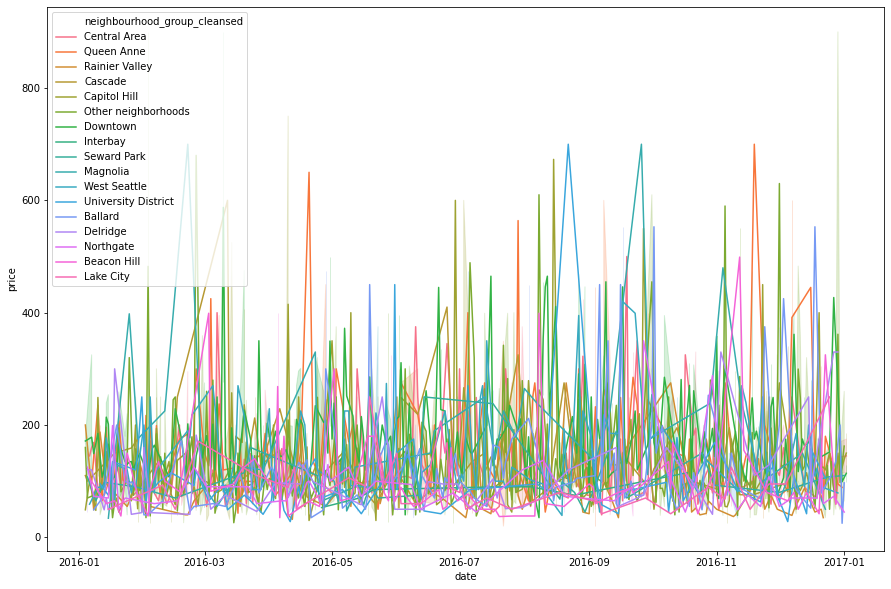

In [48]:
plt.figure(figsize = [15, 10])
sb.lineplot(data=merged_samp, x="date", y="price", hue="neighbourhood_group_cleansed")

Plot is not clear, I am going to take the three most expensive neighbourhoods and see if prices are stationary

In [49]:
merged_df = merged_df.query("(neighbourhood_group_cleansed == 'Magnolia') or (neighbourhood_group_cleansed =='Downtown') or (neighbourhood_group_cleansed == 'Queen Anne')")

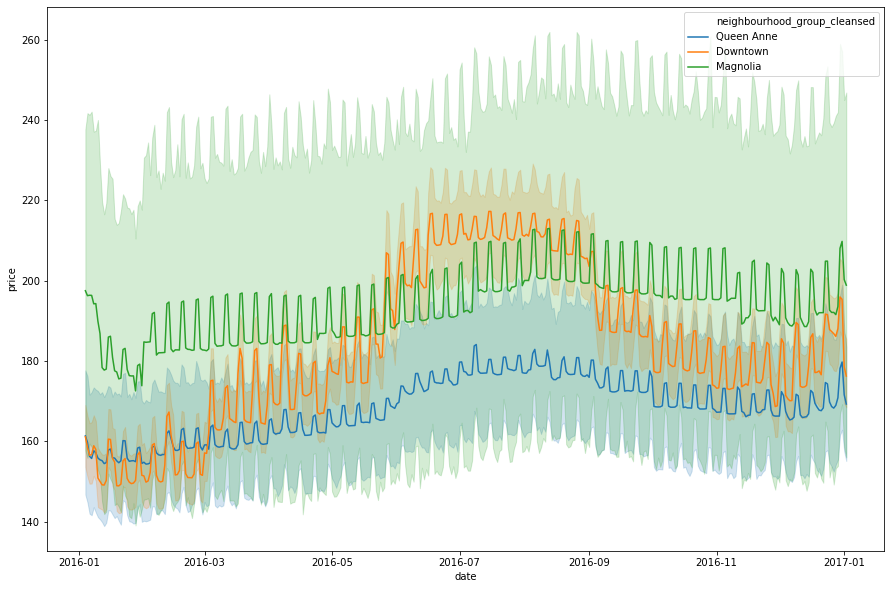

In [50]:
plt.figure(figsize = [15, 10])
sb.lineplot(data=merged_df, x="date", y="price", hue="neighbourhood_group_cleansed")

It is stationary having an increase from june to september.

## Exploratory data analysis

univariate
Histograms for price
Histograms for availability
Histograms for reviews

Text(0, 0.5, 'count')

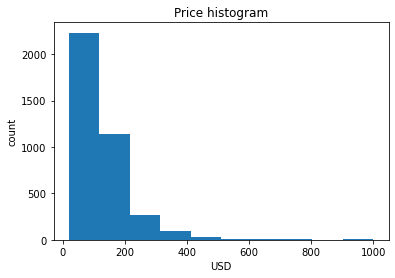

In [52]:
#price histogram
plt.hist(listings.price)
plt.title('Price histogram')
plt.xlabel('USD')
plt.ylabel('count')

Text(0, 0.5, 'count')

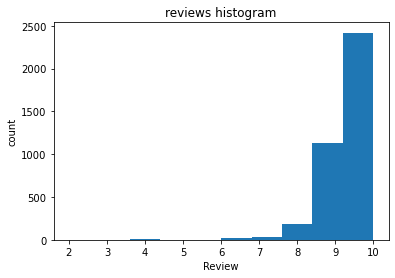

In [63]:
#reviews histogram
plt.hist(listings.review_scores_value)
plt.title('reviews histogram')
plt.xlabel('Review')
plt.ylabel('count')

Text(0, 0.5, 'count')

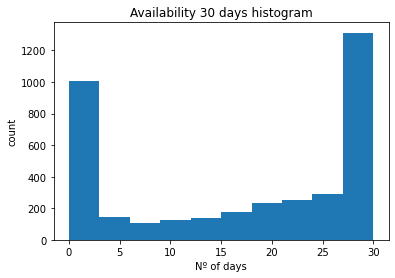

In [64]:
#availability 30 days histogram
plt.hist(listings.availability_30)
plt.title('Availability 30 days histogram')
plt.xlabel('Nº of days')
plt.ylabel('count')

In [ ]:
bivariate
reviews by price scatter
availability by price
plot neighbourhoods in map, size of point as price
plot neighbourhoods in map, size of point as availability

In [ ]:
multivariate
reviews by price and by neighbourhood top 3 and not top 3